# <center> Introdução a Análise de Sobrevivência
    
<center> <img src="https://i0.wp.com/www.jigso.com/wp-content/uploads/2020/09/Presentation-Survival-Analysis_Part-2_Keynote-grafiek-1.001.jpeg?fit=750%2C422&ssl=1" width=1000>

## Neste notebook, vamos aprender as principais bibliotecas usadas em análise de sobrevivência!

### Carregando os dados do problema

Para este problema, iremos usar dados de acompanhamento de sobrevivência de pacientes que iniciaram tratamento de **Diálise** coletados pela [Fiocruz](http://sobrevida.fiocruz.br/dialise.html)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dados de sobrevivência pós início de diálise (Fiocruz)
df = pd.read_csv('dialise.csv')

In [2]:
df.head()

,unidade,idade,inicio,fim,status,tempo,grande,causa,cdiab,crim,congenita
1,120,59,35,36,0,1,1,hip,0,0,0
2,120,49,38,41,0,3,1,hip,0,0,0
3,120,49,22,40,0,18,1,out,0,0,0
4,120,52,21,23,0,2,1,hip,0,0,0
5,120,89,41,42,1,1,1,hip,0,0,0


Descrição dos campos da base:
* `unidade`: Número do centro de diálise
* `idade`: Idade do paciente no início do tratamento
* `inicio`: Número do mês de início do tratamento (a partir de Jan/1998)
* `fim`: Número do mês de fim do acompanhamento (a partir de Jan/1998)
* `status`: Condição do dado final (0-> Censura, 1-> Óbito)
* `tempo`: Tempo em meses ate o óbito ou interrupção do acompanhamento
* `grande`: Classe do centro de diálise (1 -> 1/2 salas, 2-> 3 ou mais salas)
* `causa`: Motivação do início do tratamento:
 * `hip`: Hipertensão
 * `dia`: Diabetes
 * `ren`: Insuficiência Renal
 * `out`: Outras
* `cdiab`: Diabetes como causa da insuficiência renal (1-> Sim, 0-> Não)
* `crim`: Causas renais (1-> Sim, 0-> Não)
* `congenita`: Causas congênitas (1-> Sim, 0-> Não)

### Análise Exporatória

Sabemos que parte dos dados está `censurada`, ou seja, a informação está incompleta por dois principais motivos:
* O paciente deixou de continuar o acompanhamento
* Fim do período da pesquisa

Em ambos os casos, só podemos de fato analisar pelo EDA que conhecemos os dados completos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6805 entries, 1 to 6805
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   unidade    6805 non-null   int64 
 1   idade      6805 non-null   int64 
 2   inicio     6805 non-null   int64 
 3   fim        6805 non-null   int64 
 4   status     6805 non-null   int64 
 5   tempo      6805 non-null   int64 
 6   grande     6805 non-null   int64 
 7   causa      6805 non-null   object
 8   cdiab      6805 non-null   int64 
 9   crim       6805 non-null   int64 
 10  congenita  6805 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 638.0+ KB


In [28]:
# Proporção de dados censurados
df.status.value_counts()

0    5202
1    1603
Name: status, dtype: int64

Temos apenas **23%** dos dados finalizados!

Com os dados que estão completos, podemos ver o período de sobrevivência em relação a algumas variáveis do dataset, usando os já conhecidos `Boxplots`

In [5]:
# Filtrando dados não censurados
df_nao_censurados = df[df.status==1]

# Relação de variáveis categóricas
vars_categoricas = ['grande','causa','cdiab','crim','congenita']

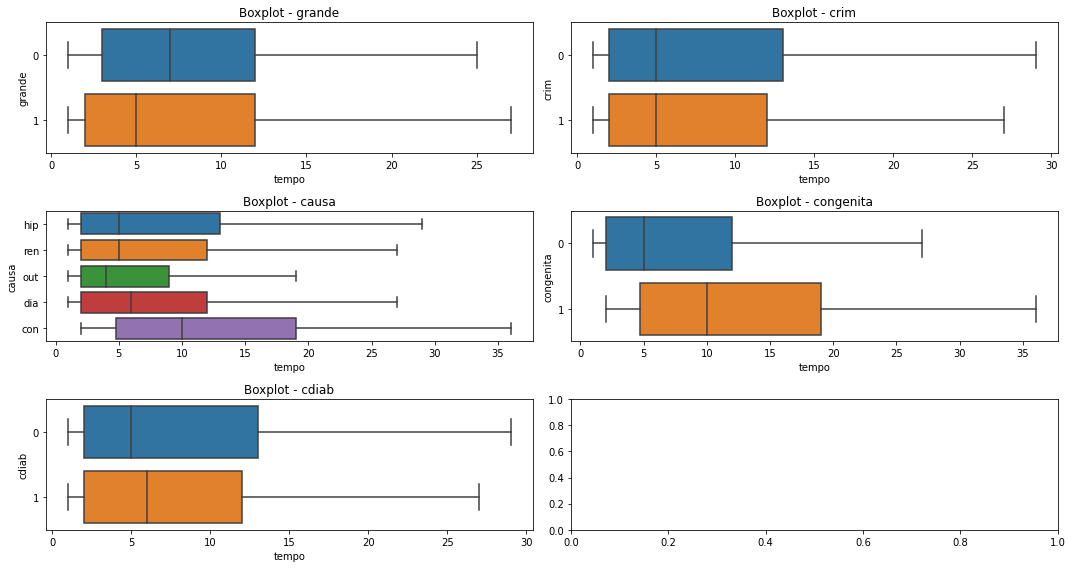

In [6]:
# Plotando boxplots para cada variável
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in range(len(vars_categoricas)):
    if i<=2:
        sns.boxplot(data=df_nao_censurados,x='tempo',y=vars_categoricas[i],orient='h', showfliers=False,ax=ax[i][0])
        ax[i][0].set_title('Boxplot - {}'.format(vars_categoricas[i]))
    else:
        sns.boxplot(data=df_nao_censurados,x='tempo',y=vars_categoricas[i],orient='h', showfliers=False,ax=ax[i-3][1])
        ax[i-3][1].set_title('Boxplot - {}'.format(vars_categoricas[i]))
plt.tight_layout()
plt.show()

Quais conclusões podemos tirar dessa análise inicial?

Os dados censurados podem também ser variáveis dependendo da origem do paciente

In [7]:
var = 'grande'
df.groupby(var)['status'].value_counts(normalize=True).to_frame()
#x[x.index.get_level_values('status')==1].plot(kind='barh')
#[x.index.get_level_values('status')==1].droplevel(1)

status
grande status          
0      0       0.785130
       1       0.214870
1      0       0.758756
       1       0.241244

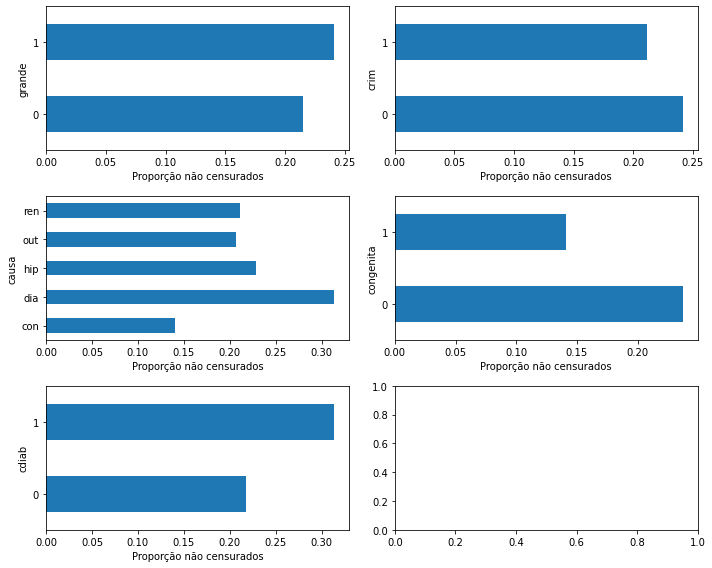

In [8]:
# Analisando proporções de valores censurados
prop_censurados = []
fig, ax = plt.subplots(3,2,figsize=(10,8))
for i in range(len(vars_categoricas)):
    # Filtrando apenas 
    aux = df.groupby(vars_categoricas[i])['status'].value_counts(normalize=True)
    # Filtrando apenas status 0 (censurado) e plotando a proporção
    if i<=2:
        aux[aux.index.get_level_values('status')==1].droplevel(1).plot(kind='barh',ax=ax[i][0])
        ax[i][0].set_xlabel('Proporção não censurados')
    else:
        aux[aux.index.get_level_values('status')==1].droplevel(1).plot(kind='barh',ax=ax[i-3][1])
        ax[i-3][1].set_xlabel('Proporção não censurados')
plt.tight_layout()
plt.show()

Onde temos a maior proporção de dados censurados?

### Estimativas de Kaplan-Meier

Vamos agora construir algumas estimativa de curvas de sobrevivência usando o modelo de `Kaplan-Meier`

Para isso, vamos usar uma biblioteca própria para isso, a `lifelines`

In [9]:
# Caso não tenha a biblioteca, descomente e rode a linha abaixo!
#!pip install lifelines

Vamos começar construindo o gráfico das linhas de sobrevivência

In [10]:
from lifelines.plotting import plot_lifetimes

Podemos também construir o gráfico de linhas de sobrevivência. Como o gráfico consome espaço, é adequado pegar apenas alguns registros de amostra (aqui pegamos 50)

C:\ProgramData\Anaconda3\lib\site-packages\lifelines\plotting.py:710: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


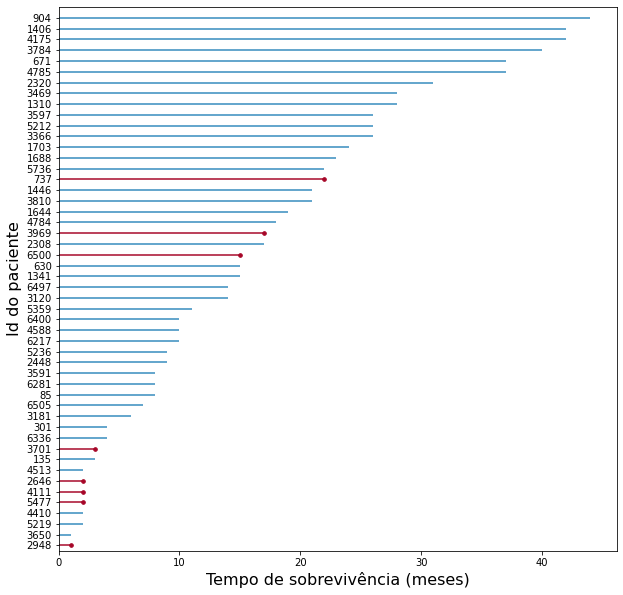

In [11]:
# Amostrando usuários
df_amostra = df.sample(50)

plt.figure(figsize=(10,10))
plot_lifetimes(df_amostra['tempo'],df_amostra['status'])
plt.ylabel('Id do paciente',size=16)
plt.xlabel('Tempo de sobrevivência (meses)',size=16)
plt.show()


In [12]:
# Importando a curva de KaplanMeier
from lifelines import KaplanMeierFitter

# Instanciando o construtor da curva
kmf = KaplanMeierFitter() 
# Usamos um .fit() para ajustar, fornecendo os dados de tempos de sobrevivência e censuras
kmf.fit(df['tempo'],df['status'],label='Total') 

<lifelines.KaplanMeierFitter:"Total", fitted with 6805 total observations, 5202 right-censored observations>

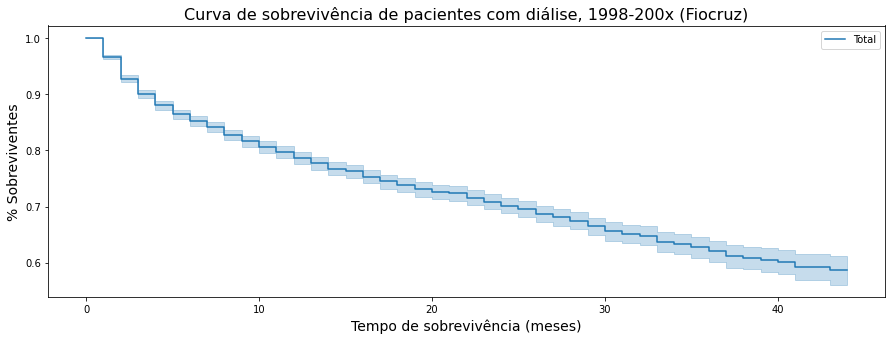

In [13]:
# Plotando os dados
plt.figure(figsize=(15,5))
kmf.plot()
plt.xlabel('Tempo de sobrevivência (meses)',size=14)
plt.ylabel('% Sobreviventes',size=14)
plt.title('Curva de sobrevivência de pacientes com diálise, 1998-200x (Fiocruz)',size=16)
plt.show()

Como vamos estimar a curva de `Kaplan-Meier` algumas vezes, vamos transformar esse processo em uma função:

In [14]:
def grafico_kaplanmeier(dados,nome):
    kmf = KaplanMeierFitter().fit(dados['tempo'],dados['status'],label=nome)
    kmf.plot()
    plt.xlabel('Tempo de sobrevivência (meses)',size=14)
    plt.ylabel('% Sobreviventes',size=14)
    plt.title('Curva de sobrevivência de pacientes com diálise, 1995-1998 (Fiocruz)',size=16)

Podemos agora plotar as curvas de Kaplan-Meier para os subconjuntos de dados!

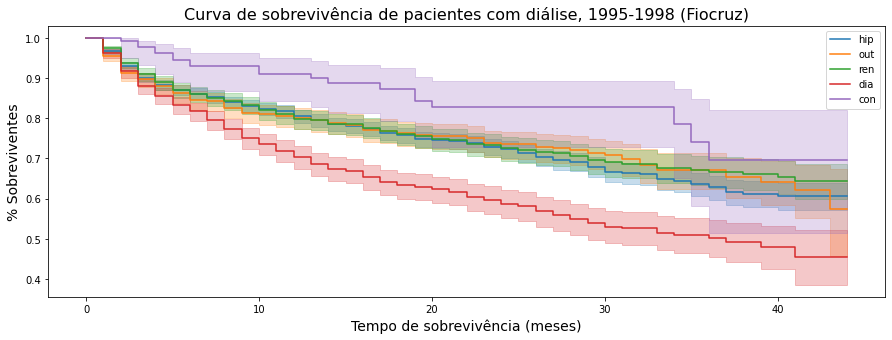

In [15]:
# Curvas de Kaplan-Meier para os diferentes tipos de diagnóstico
variavel = 'causa'
plt.figure(figsize=(15,5))
for i in df[variavel].unique():
    #print(i)
    grafico_kaplanmeier(df[df[variavel]==i],nome=i)
    plt.legend()

Mesmo com as incertezas, qual das causas parece ser mais letal? E a menos letal?

### Como comparar curvas estatisticamente?

No caso anterior vimos múltiplas curvas com suas respectivas barras de incerteza. Como saber, então, se **duas curvas de sobrevivência são estatisticamente diferentes**?

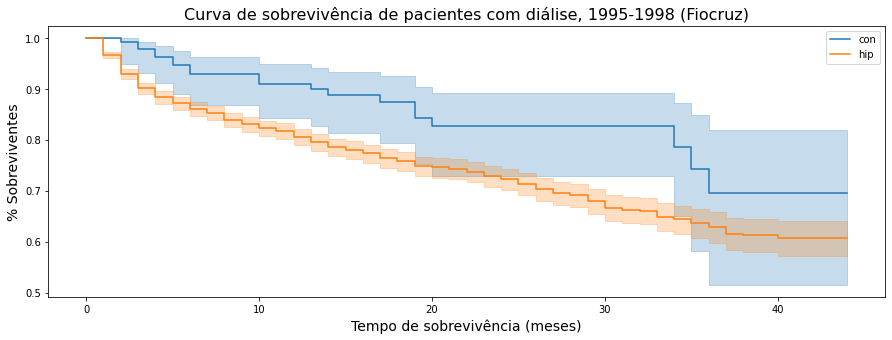

In [16]:
# Curvas de Kaplan-Meier para os diferentes tipos de diagnóstico
variavel = 'causa'
plt.figure(figsize=(15,5))
for i in ['con','hip']:
    #print(i)
    grafico_kaplanmeier(df[df[variavel]==i],nome=i)
    plt.legend()

Dada a incerteza, será que essas duas séries são estatisticamente distintas? Para este teste, podemos usar o teste `LogRank`. Ele assume o seguinte teste de hipótese:
* **H0**: As curvas são iguais por possuírem o mesmo `Hazard` (perigo) estatisticamente
* **H1**: As curvas são _diferentes_, possuindo diferentes `Hazard` (perigos)

In [17]:
from lifelines.statistics import logrank_test

# Filtrando duas séries diferentes 
serie_con = df[df.causa=='con']
serie_hip = df[df.causa=='hip']

# Executando o teste
logrank_test(
    serie_con['tempo'],serie_hip['tempo'], # Tempos da primeira e da segunda série
    serie_con['status'],serie_hip['status'] # Marcações da primeira e da segunda série
)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.71 0.01      7.51

O número que estamos interessados é o `p` que é a significância do teste. Usando o limite de `5%` padrão em testes de hipótese:
* Se **p>=0.05**, a hipótese nula não é rejeitada (as curvas são iguais)
* Se **p<0.05**, a hipótese nula é rejeitada (as curvas são _diferentes_)

Podemos usar também o `multivariate_logrank_test` para testar dentre várias curvas e avaliar se existe pelo menos uma que é diferente das demais! Testamos individualmente para as condições de `hipertensão` e `congênita`, mas agora podemos testar para todas as condições ao mesmo tempo!

In [18]:
# Importando o módulo
from lifelines.statistics import multivariate_logrank_test

# Instanciando o teste
teste_multiplo = multivariate_logrank_test(df['tempo'], df['causa'], df['status'])
teste_multiplo.test_statistic
teste_multiplo.p_value
teste_multiplo.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          70.51 <0.005     45.68

Nós já sabíamos pelo teste anterior, mas agora tivemos a certeza de que há séries diferentes dentro do agrupamento `causa`! E quanto às outras características?

In [19]:
# Testando as demais características
vars_categoricas = ['grande','causa','cdiab','crim','congenita']
for i in vars_categoricas:
    teste = multivariate_logrank_test(df['tempo'], df[i], df['status']) # i é a variável que queremos testar
    if teste.p_value<=0.05:
        print("Variável {}: TEM séries diferentes".format(i))
    else:
        print("Variável {}: NÃO TEM séries diferentes".format(i))

Variável grande: TEM séries diferentes
Variável causa: TEM séries diferentes
Variável cdiab: TEM séries diferentes
Variável crim: TEM séries diferentes
Variável congenita: TEM séries diferentes


Todas as variáveis possuem séries distintas, e isso é importante! Pois a sobrevivência é então diferente de acordo com cada motivação do paciente iniciar o tratamento de diálise. Essas conclusões podem ser muito úteis tanto em saúde quanto no problema que estamos analisando em geral

### A abordagem exponencial

Vimos também a possibilidade de usar uma `função exponencial` para representar a função de sobrevivência. Ela também está implementada na biblioteca `lifelines`, com o nome `ExponentialFitter`

In [20]:
# Importando o módulo
from lifelines.fitters.exponential_fitter import ExponentialFitter

# Instanciando o objeto
ef = ExponentialFitter()

# Ajustando aos dados
ef.fit(df['tempo'],df['status'],label='Total')

<lifelines.ExponentialFitter:"Total", fitted with 6805 total observations, 5202 right-censored observations>

Da mesma forma que com o `KaplanMeierFitter`, podemos também construir o gráfico resultante pelo método `.plot()`

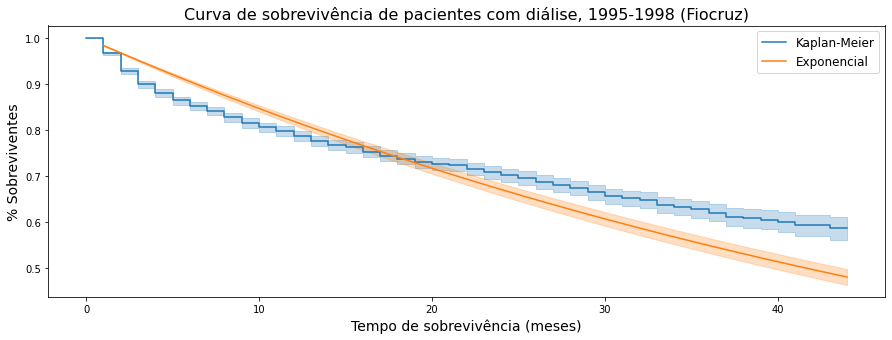

In [21]:
# Construindo o gráfico e comparando com a abordagem de Kaplan-Meier
# Plotando os dados
plt.figure(figsize=(15,5))
kmf.plot()
ef.plot_survival_function()
plt.xlabel('Tempo de sobrevivência (meses)')
plt.xlabel('Tempo de sobrevivência (meses)',size=14)
plt.ylabel('% Sobreviventes',size=14)
plt.title('Curva de sobrevivência de pacientes com diálise, 1995-1998 (Fiocruz)',size=16)
plt.legend(['Kaplan-Meier','Exponencial'],prop={'size': 12})
plt.show()

Também podemos construir as curvas específicas para cada tipo de causa, como fizemos anteriormente:

In [22]:
# Definindo a função de ajuste exponencial
def grafico_exponencial(dados,nome):
    kmf = ExponentialFitter().fit(dados['tempo'],dados['status'],label=nome)
    kmf.plot_survival_function()
    plt.xlabel('Tempo de sobrevivência (meses)',size=14)
    plt.ylabel('% Sobreviventes',size=14)
    plt.title('Curva de sobrevivência de pacientes com diálise, 1995-1998 (Fiocruz)',size=16)

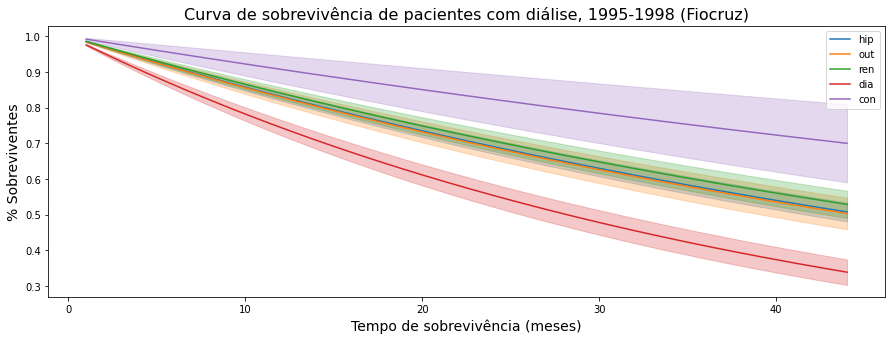

In [23]:
# Curvas de Kaplan-Meier para os diferentes tipos de diagnóstico
variavel = 'causa'
plt.figure(figsize=(15,5))
for i in df[variavel].unique():
    grafico_exponencial(df[df[variavel]==i],nome=i)
    plt.legend()

Pelas incertezas serem menores, fica muito mais evidente o fato de que há duas causas com sobrevivências bem distintas: `diabetes` e `congênita`

Agora que temos acesso às curvas exponenciais, podemos extrair a estimativa de `Perigo` de cada uma delas, através do parámetro `.hazard`

In [24]:
ef.hazard_.head()

,Total
1.000000,0.016638
1.086172,0.016638
1.172345,0.016638
1.258517,0.016638
1.344689,0.016638


Como premissa da abordagem exponencial, o `Perigo` é constante em todos os momentos, por isso o valor é constante no DataFrame

Com esse novo comparativo, podemos descobrir quais motivadores de diálise são mais arriscados, comparando os valores! 

In [30]:
perigo_relativo = 0.025/0.007
perigo_relativo

3.5714285714285716

[]

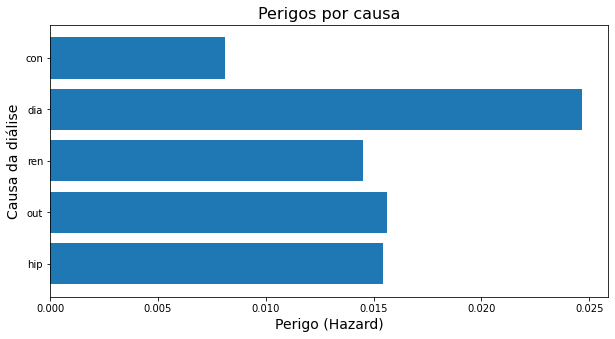

In [25]:
variavel = 'causa'
perigos = []
for i in df[variavel].unique():
    aux = df[df.causa==i]
    ef = ExponentialFitter().fit(aux['tempo'],aux['status'],label=variavel)
    perigos.append((i,ef.hazard_.mean().values[0]))
    
# Plotando os perigos
plt.figure(figsize=(10,5))
n, p = list(zip(*perigos))
plt.barh(n,p)
plt.xlabel('Perigo (Hazard)',size=14) 
plt.ylabel('Causa da diálise',size=14)
plt.title('Perigos por causa',size=16)
plt.plot()

In [26]:
# Hazard Ratio
0.024636289904076965/0.014499073970424211

1.6991629916731958

Qual causa parece ser a mais sensível em relação à sobrevivência?

## <center> Relembrando o que vimos!

<center> <img src="https://c.tenor.com/qqoyLT6bBSgAAAAC/how-did-i-survive-how-did-i-make-it.gif" width=1000>

* Análise de sobrevivência é um conjunto de técnicas que vai além por explorar dados `censurados`, ou seja, sem o acesso completo à informação da nossa variável de interesse, o que faz com que muito mais dados possam ser analisados
* As principais técnicas que vimos foram a da construção da curva de `Kaplan-Meier`(abordagem não paramétrica) e a `exponencial` (abordagem paramétrica). (Semi-paramétrica: Weibull-Cox)
* Em especial na abordagem paramétrica exponencial é possível extrair uma medida de `Perigo (Hazard)`, que avalia a probabilidade do evento ocorrer nos próximos instantes dado que ele ainda não ocorreu.

# <center> Muito obrigado a todos!!!
    
<center> <img src="https://s.studiobinder.com/wp-content/uploads/2020/07/Michael-Scott-Wayne-Gretzsky-Quotes.jpg?resolution=1680,0.75" width=1500>